In [ ]:
!pip install pydriller

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 4.9 MB/s eta 0:00:00


In [ ]:
import os
import shutil
import tempfile
from typing import List, Tuple, Dict
import pandas as pd
from tqdm import tqdm
from pydriller import Repository
from pydriller.domain.commit import ModificationType
from git import Repo, GitCommandError

def ensure_local_checkout(repo_spec: str, base_dir: str) -> str:
    if os.path.isdir(repo_spec) and os.path.isdir(os.path.join(repo_spec, ".git")):
        return os.path.abspath(repo_spec)
    target = os.path.join(base_dir, os.path.basename(repo_spec.rstrip("/")).replace(".git", ""))
    if os.path.exists(target):
        shutil.rmtree(target)
    Repo.clone_from(repo_spec, target)
    return target

In [ ]:
def run_git_diff_for_file(repo: Repo, parent_sha: str, commit_sha: str, rel_path: str, algorithm: str) -> str:
    flags = ["-w", "--ignore-blank-lines", f"--diff-algorithm={algorithm}"]
    try:
        return repo.git.diff(parent_sha, commit_sha, *flags, "--", rel_path)
    except GitCommandError:
        return ""

def normalize_line_endings(text: str) -> str:
    if not text:
        return ""
    return text.replace("\r\n", "\n").replace("\r", "\n")

In [ ]:
def get_git_diffs_and_stats(repo_path: str, parent_sha: str, commit_sha: str, file_path: str) -> Dict:
    repo = Repo(repo_path)
    rel_path = file_path
    myers_raw = run_git_diff_for_file(repo, parent_sha, commit_sha, rel_path, "myers")
    hist_raw = run_git_diff_for_file(repo, parent_sha, commit_sha, rel_path, "histogram")
    myers_hunks, myers_changed = count_hunks_and_changed_lines(myers_raw)
    hist_hunks, hist_changed = count_hunks_and_changed_lines(hist_raw)
    discrepancy = "No" if (myers_hunks == hist_hunks and myers_changed == hist_changed) else "Yes"
    return {
        "diff_myers": normalize_line_endings(myers_raw),
        "diff_hist": normalize_line_endings(hist_raw),
        "myers_hunks": myers_hunks,
        "myers_changed_lines": myers_changed,
        "hist_hunks": hist_hunks,
        "hist_changed_lines": hist_changed,
        "Discrepancy": discrepancy
    }

In [ ]:
def count_hunks_and_changed_lines(diff_text: str) -> Tuple[int, int]:
    if not diff_text:
        return 0, 0
    text = normalize_line_endings(diff_text)
    hunks = 0
    changed_lines = 0
    for line in text.split("\n"):
        if line.startswith("@@"):
            hunks += 1
            continue
        if line.startswith("+++ ") or line.startswith("--- ") or line.startswith("diff ") or line.startswith("index "):
            continue
        if line.startswith("+") or line.startswith("-"):
            changed_lines += 1
    return hunks, changed_lines

In [ ]:
def mine_repos(repo_list, output_csv: str = "consolidated_pydriller.csv"):
    rows = []
    with tempfile.TemporaryDirectory() as tmpdir:
        local_paths = [ensure_local_checkout(r, tmpdir) for r in repo_list]
        for repo_path in local_paths:
            repo_name = os.path.basename(repo_path)
            for commit in tqdm(
                Repository(
                    repo_path,
                    only_modifications_with_file_types=['.py']
                ).traverse_commits(),
                desc=f"Mining {repo_name}"
            ):
                if not commit.parents:
                    continue
                parent_sha = commit.parents[0]
                for m in commit.modified_files:
                    if m.change_type != ModificationType.MODIFY:
                        continue
                    if getattr(m, "is_binary", False):
                        continue
                    old_path = m.old_path or m.new_path
                    new_path = m.new_path or m.old_path
                    file_for_diff = new_path or old_path
                    if file_for_diff is None:
                        continue
                    stats = get_git_diffs_and_stats(repo_path, parent_sha, commit.hash, file_for_diff)
                    rows.append({
                        "old_file_path": old_path,
                        "new_file_path": new_path,
                        "commit_sha": commit.hash,
                        "parent_commit_sha": parent_sha,
                        "commit_message": (commit.msg or "").strip(),
                        "diff_myers": stats["diff_myers"],
                        "diff_hist": stats["diff_hist"],
                        "myers_hunks": stats["myers_hunks"],
                        "myers_changed_lines": stats["myers_changed_lines"],
                        "hist_hunks": stats["hist_hunks"],
                        "hist_changed_lines": stats["hist_changed_lines"],
                        "Discrepancy": stats["Discrepancy"],
                        "repo": repo_name,
                        "commit_author_date": commit.author_date.isoformat()
                    })
    df = pd.DataFrame(rows, columns=[
        "old_file_path", "new_file_path",
        "commit_sha", "parent_commit_sha",
        "commit_message", "diff_myers", "diff_hist",
        "myers_hunks", "myers_changed_lines",
        "hist_hunks", "hist_changed_lines",
        "Discrepancy",
        "repo", "commit_author_date"
    ])
    df.to_csv("output_csv", index=False)
    return df

In [ ]:
repos = [
    "https://github.com/Aider-AI/aider.git",
    "https://github.com/aws/aws-cli.git",
    "https://github.com/apache/airflow.git",
]
df = mine_repos(repos, output_csv="all_repos_consolidated.csv")

Mining aider: 7930it [02:23, 55.38it/s]
Mining aws-cli: 4814it [04:31, 17.72it/s]
Mining airflow: 22197it [27:30, 13.45it/s]


Done! Consolidated CSV saved to: all_repos_consolidated.csv  | Rows: 186976


In [ ]:
import pandas as pd

def count_changes(diff_text: str) -> int:
    return sum(1 for line in str(diff_text).splitlines()
               if (line.startswith('+') or line.startswith('-'))
               and not line.startswith('+++') and not line.startswith('---'))

def count_hunks(diff_text: str) -> int:
    return sum(1 for line in str(diff_text).splitlines()
               if line.startswith('@@'))

df["myers_changes"] = df["diff_myers"].apply(count_changes)
df["hist_changes"] = df["diff_hist"].apply(count_changes)
df["myers_hunks"] = df["diff_myers"].apply(count_hunks)
df["hist_hunks"] = df["diff_hist"].apply(count_hunks)

def pick_winner(row):
    if row["myers_changes"] < row["hist_changes"]:
        return "myers"
    elif row["hist_changes"] < row["myers_changes"]:
        return "hist"
    else:
        if row["myers_hunks"] < row["hist_hunks"]:
            return "myers"
        elif row["hist_hunks"] < row["myers_hunks"]:
            return "hist"
        else:
            return "tie"

df["better_algo"] = df.apply(pick_winner, axis=1)

results = df["better_algo"].value_counts()
print(results)


better_algo
tie      183681
myers      1514
hist        626
Name: count, dtype: int64


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def classify_file(path):
    if pd.isna(path):
        return None
    path = path.lower()
    if "test" in path and path.endswith(".py"):
        return "Test Code"
    elif path.endswith(".py"):
        return "Source Code"
    elif "readme" in path:
        return "README"
    elif "license" in path:
        return "LICENSE"
    else:
        return None

df["File Type"] = df["old_file_path"].apply(classify_file)

In [ ]:
df["File Type"].value_counts().values

array([87702, 44103,  2521,    61])

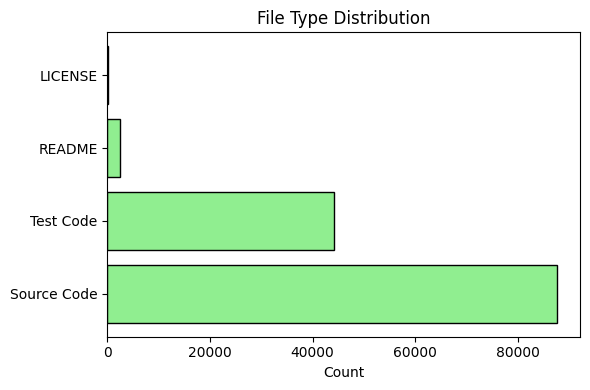

In [ ]:
plt.figure(figsize=(6,4))
plt.barh(df["File Type"].value_counts().index, df["File Type"].value_counts().values, color="lightgreen", edgecolor="black")
plt.title("File Type Distribution")
plt.xlabel("Count")
plt.tight_layout()
plt.show()


In [ ]:
new_df = df[['old_file_path', 'new_file_path', 'commit_sha', 'parent_commit_sha',
       'commit_message', 'diff_myers', 'diff_hist', 'myers_hunks',
       'myers_changed_lines', 'hist_hunks', 'hist_changed_lines',
       'Discrepancy','better_algo', 'File Type']].iloc[:1000]

In [ ]:
new_df

,old_file_path,new_file_path,commit_sha,parent_commit_sha,commit_message,diff_myers,diff_hist,myers_hunks,myers_changed_lines,hist_hunks,hist_changed_lines,Discrepancy,better_algo,File Type
0,coder.py,coder.py,6fc98423c61c0986b5c1c16551ade3488bf2be19,41aed411ea2ba2544d10f23ec30d6089056e8953,better,diff --git a/coder.py b/coder.py\nindex 2c15ce...,diff --git a/coder.py b/coder.py\nindex 2c15ce...,3,72,3,72,No,tie,Source Code
1,coder.py,coder.py,1f4706e0e7bca69458a0f294375fb53868589919,6fc98423c61c0986b5c1c16551ade3488bf2be19,worked,diff --git a/coder.py b/coder.py\nindex 06632e...,diff --git a/coder.py b/coder.py\nindex 06632e...,4,36,4,36,No,tie,Source Code
2,coder.py,coder.py,62c41c6b5b549f26e5ab8f99dac61671ba90d218,1f4706e0e7bca69458a0f294375fb53868589919,better,diff --git a/coder.py b/coder.py\nindex 7c9da4...,diff --git a/coder.py b/coder.py\nindex 7c9da4...,2,9,2,9,No,tie,Source Code
3,coder.py,coder.py,8e0498a35ff95c31aba5b953bccb6ff6c9c24f3a,62c41c6b5b549f26e5ab8f99dac61671ba90d218,does not work,diff --git a/coder.py b/coder.py\nindex 25c16b...,diff --git a/coder.py b/coder.py\nindex 25c16b...,2,10,2,10,No,tie,Source Code
4,coder.py,coder.py,692e649c3fbf7645a0161f6d132b5725e68dcb3c,8e0498a35ff95c31aba5b953bccb6ff6c9c24f3a,works,diff --git a/coder.py b/coder.py\nindex d0133e...,diff --git a/coder.py b/coder.py\nindex d0133e...,4,86,4,86,No,tie,Source Code
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,aider/prompts.py,aider/prompts.py,4f1e1181c45a37529c61f36469e9230b5f1b1df8,bd81ef6201816501033e41bfd19b94d8ec6e1fde,Tweaked prompt,diff --git a/aider/prompts.py b/aider/prompts....,diff --git a/aider/prompts.py b/aider/prompts....,1,4,1,4,No,tie,Source Code
996,aider/repomap.py,aider/repomap.py,c5ed12e0c32866be324b6827a13f863c8f807ada,100deccbff77d5179036ec8b1960f1c594391fbe,aider: Replaced shelve with diskcache for pers...,diff --git a/aider/repomap.py b/aider/repomap....,diff --git a/aider/repomap.py b/aider/repomap....,3,17,3,17,No,tie,Source Code
997,aider/repomap.py,aider/repomap.py,575c6e2db61f1d779dafaa47079c368989d8cd24,c5ed12e0c32866be324b6827a13f863c8f807ada,Stop closing,diff --git a/aider/repomap.py b/aider/repomap....,diff --git a/aider/repomap.py b/aider/repomap....,2,7,2,7,No,tie,Source Code
998,aider/coder.py,aider/coder.py,1882cf55db78be1ea52581be886badb7c5224562,4f1e1181c45a37529c61f36469e9230b5f1b1df8,Handle ConnectionError,diff --git a/aider/coder.py b/aider/coder.py\n...,diff --git a/aider/coder.py b/aider/coder.py\n...,2,6,2,6,No,tie,Source Code


In [ ]:
new_df.to_csv("Lab4final.csv")